# Intro

## CNN Architecture

- Conv layer - 6 filters, 3x3 size, stride 1
- Pooling layer - 2x2 size, stride 2
- Conv layer - 16 filters, 3x3 size, stride 1
- Pooling layer - 2x2 size, stride 2
- Fully connected - 46,656* > 120 > 84 > 2
*See calculation below

In [5]:
# Calculating fully connected layers input
c1 = output_size(224,3,0,1)
p1 = output_size(c1,2,0,2)
c2 = output_size(p1,3,0,1)
p2 = output_size(c2,2,0,2)

print(f'C1: {c1} > P1: {p1} > C2: {c2} > P2: {p2} = {int(p2)} pixels per side')
print(f'Fully connected layers inputs = {int(p2)**2*16:,} > {int(p2)} pixels squared x number of channels')

C1: 222.0 > P1: 111.0 > C2: 109.0 > P2: 54.5 = 54 pixels per side
Fully connected layers inputs = 46,656 > 54 pixels squared x number of channels


# Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def output_size(w,k,p,s):
    '''
    Calculates the output size of a convolution/pooling layer.
    - w [int]: input volume
    - k [int]: Kernel size
    - p [int]: padding
    - s [int]: stride
    '''
    return ((w-k+2*p)/s)+1

# Transforms

We will be creating two transform objects, one for train data, and one for test data. 

In [6]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

Images do not need to be augmented in the test set. 

In [7]:
test_transfrom = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Data sets and loaders

Loading the data can be done with the `datasets.ImageFolder` class.

In [8]:
root = '../Data/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=train_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True,num_workers=3)
test_loader = DataLoader(test_data,batch_size=10,shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data):,}')
print(f'Testing images available:  {len(test_data):,}')

['CAT', 'DOG']
Training images available: 18,743
Testing images available:  6,251


# Reviewing data

In [11]:
# Grab the first batch of images
for images, labels in train_loader:
    break

In [31]:
# Print labels and classes
print(f'labels:\n{labels.numpy().reshape(2,-1)}')
print(f'classes:\n{np.array([class_names[i] for i in labels.numpy()]).reshape(2,-1)}')

labels:
[[0 0 1 1 1]
 [0 1 0 1 0]]
classes:
[['CAT' 'CAT' 'DOG' 'DOG' 'DOG']
 ['CAT' 'DOG' 'CAT' 'DOG' 'CAT']]


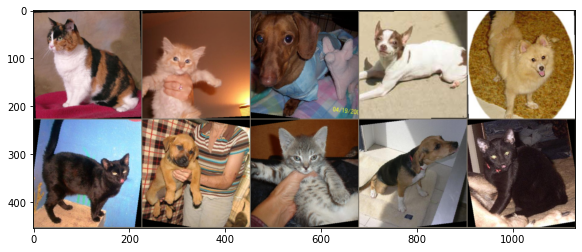

In [27]:
# Visualise images
im = make_grid(images,nrow=5)
inv_norm = transforms.Normalize([-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                [1/0.229,1/0.224,1/0.225])

inv_im = inv_norm(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(inv_im.numpy(),(1,2,0)))

# Defining the model

In [32]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(54**2*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        
        # Data needs to be flattened before ran into the linear layers
        X = X.view(-1,54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

- Conv layer - 6 filters, 3x3 size, stride 1
- Pooling layer - 2x2 size, stride 2
- Conv layer - 16 filters, 3x3 size, stride 1
- Pooling layer - 2x2 size, stride 2
- Fully connected - 46,656* > 120 > 84 > 2

In [34]:
# Initialise our model
CNNmodel = ConvolutionalNetwork()

In [36]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

## Loss and optimisation functions

In [35]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

## Parameter calculation

In [41]:
n_param = 0
for param in CNNmodel.parameters():
    print(f'{param.numel():10,}')
    n_param += param.numel()
print(f'----------\n{n_param:10,}')

       162
         6
       864
        16
 5,598,720
       120
    10,080
        84
       168
         2
----------
 5,610,222


# Training